# Menu <a class="anchor" id="menu"></a>
* [1. Feature Engineering](#feature_engineering)
* [2. Préparation du jeu de données](#models_prepare)
* [3. Améliorer les modèles avec de `nouvelles features`](#models_feature_engineering)
    * [3.1 Logistic Regression](#models_linear_new_features)
    * [3.2 XGBoost Classifier](#models_xgboost_new_features)
* [4. Optimizer le modèle avec une `features selection`](#models_feature_selection)
    * [4.1 Logistic Regression](#models_linear_features_selection)
    * [4.2 XGBoost Classifier](#models_xgboost_features_selection)
* [5. Optimizer le modèle avec une `mesure adaptée`](#models_new_metrics)
    * [5.0 Création d'une mesure adaptée](#custom_metric)
    * [5.1 Logistic Regression](#models_linear_new_metrics)
    * [5.2 XGBoost Classifier](#models_xgboost_new_metrics)

# Mise en place

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px

np.random.seed(0) # Seed the unexpected randomness of this world

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [5]:
sample_size_base = 30000
sample_size_grid = 30000
data_work = data_application_train[:sample_size_base].copy()

In [6]:
data_work.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",False,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,False,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Créons de `nouvelles features` métiers <a class="anchor" id="feature_engineering"></a> [⇪](#menu)

### Quelle fraction du bien convointé représente le montant du crédit ?

In [7]:
data_work['FRAC_GOODS_PRICE'] = data_work.AMT_CREDIT / data_work.AMT_GOODS_PRICE

In [8]:
data_work[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

,AMT_CREDIT,AMT_GOODS_PRICE,FRAC_GOODS_PRICE
0,406597.5,351000.0,1.158397
1,1293502.5,1129500.0,1.145199
2,135000.0,135000.0,1.000000
3,312682.5,297000.0,1.052803
4,513000.0,513000.0,1.000000


### Quel age (en années) avait le client quand il a obtenu son emploi actuel ?

In [9]:
data_work['AGE_EMPLOYEMENT'] = (data_work.DAYS_BIRTH - data_work.DAYS_EMPLOYED) / -365

In [10]:
data_work[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,AGE_EMPLOYEMENT
0,-9461,-637,24.175342
1,-16765,-1188,42.676712
2,-19046,-225,51.564384
3,-19005,-3039,43.742466
4,-19932,-3038,46.284932


### Quel montant de revenu est disponible pour chaque membre de la famille ?

In [11]:
data_work['INCOME_PER_FAM_MEMBER'] = data_work.AMT_INCOME_TOTAL / data_work.CNT_FAM_MEMBERS

In [12]:
data_work[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,INCOME_PER_FAM_MEMBER
0,202500.0,1.0,202500.0
1,270000.0,2.0,135000.0
2,67500.0,1.0,67500.0
3,135000.0,2.0,67500.0
4,121500.0,1.0,121500.0


### Combien de demandes de crédits ont été faites au total ?

In [13]:
data_work['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_work.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_DAY +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_MON +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_QRT +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_YEAR

In [14]:
data_work[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_TOTAL
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Title TODO

In [15]:
data_work['ANNUITY_INCOME_RATIO'] = data_work.AMT_INCOME_TOTAL / data_work.AMT_ANNUITY

### Title TODO

In [16]:
data_work['DIFF_GOOD_PRICE_CREDIT'] = data_work.AMT_GOODS_PRICE - data_work.AMT_CREDIT

### Title TODO

In [17]:
data_work['AGE_INT'] = data_work.DAYS_BIRTH / -365

### Ajoutons les nouvelles features au jeu de données

In [18]:
data_work2 = data_work.copy()

In [19]:
data_work2['FRAC_GOODS_PRICE'] = data_work['FRAC_GOODS_PRICE']
data_work2['AGE_EMPLOYEMENT'] = data_work['AGE_EMPLOYEMENT']
data_work2['INCOME_PER_FAM_MEMBER'] = data_work['INCOME_PER_FAM_MEMBER']
data_work2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_work['AMT_REQ_CREDIT_BUREAU_TOTAL']

data_work2['ANNUITY_INCOME_RATIO'] = data_work['ANNUITY_INCOME_RATIO']
data_work2['DIFF_GOOD_PRICE_CREDIT'] = data_work['DIFF_GOOD_PRICE_CREDIT']
data_work2['AGE_INT'] = data_work['AGE_INT']

### Vérifions la corrélation linéaire des nouvelles variables avec TARGET

In [20]:
correlations = data_work2.corr(method='pearson')

In [21]:
new_features = [
    'FRAC_GOODS_PRICE', 
    'AGE_EMPLOYEMENT', 
    'INCOME_PER_FAM_MEMBER', 
    'AMT_REQ_CREDIT_BUREAU_TOTAL', 
    'ANNUITY_INCOME_RATIO', 
    'DIFF_GOOD_PRICE_CREDIT', 
    'AGE_INT'
]

corr_target = correlations.TARGET.sort_values(ascending=False)
for i, (key, value) in enumerate(corr_target.iteritems()):
    if key in new_features:
        print(f"{key.rjust(40)} : {value:6.4f}")

                        FRAC_GOODS_PRICE : 0.0636
             AMT_REQ_CREDIT_BUREAU_TOTAL : 0.0187
                    ANNUITY_INCOME_RATIO : 0.0145
                   INCOME_PER_FAM_MEMBER : 0.0139
                  DIFF_GOOD_PRICE_CREDIT : -0.0240
                         AGE_EMPLOYEMENT : -0.0406
                                 AGE_INT : -0.0809


# Préparons le jeu de données <a class="anchor" id="models_prepare"></a> [⇪](#menu)

Nous allons utiliser exactement la même approche que lors du Spot Checking des models *(02_Spot_cheking_models.ipynb)*.

### Découpage du jeu de données  <a class="anchor" id="models_prepare_split"></a> [⇪](#menu)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_full = data_work2.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_work2['TARGET']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [25]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


### Encodage des données non-numériques <a class="anchor" id="models_prepare_encode"></a> [⇪](#menu)

In [26]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder #, LabelEncoder

In [27]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = [x for x in ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'] if x in data.columns]
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_model):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

In [28]:
oe_model, ohe_model = fit_labels(X_train)

In [29]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations des données manquantes <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

In [30]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [31]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    
    return dt

In [32]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [33]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)

### Normalisation du jeu de données <a class="anchor" id="models_prepare_normalize"></a> [⇪](#menu)

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [36]:
model_scaler = fit_normalizer(X_train)

In [37]:
X_train = normalize(X_train, model_scaler)
X_test = normalize(X_test, model_scaler)

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

In [38]:
from sklearn.metrics import fbeta_score, make_scorer

In [39]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2)
f2_scorer = make_scorer(fbeta_score, beta=2)

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [41]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [42]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [43]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [44]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [45]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    custom =  scores.get('custom', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, custom, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [46]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'Custom', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores_tuning.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'custom': f2_score(y_ref, y_pred),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [47]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [48]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [49]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV # --> trop lent


def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=0)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{str(scoring).upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{str(scoring).upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [50]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [51]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [52]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

# Testons les modèles sélectionnés avec les nouvelles features<a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

--- 
>#### Voici pour rappel les deux modèles que l'on a choisi d'essayer d'améliorer:
> - la `Balanced LogisticRegression`:
>   - ROC_AUC : 0.7309
>   - F1 : 0.2433
>   - ACCURACY : 0.6751
>   - PRECISION : 0.1495
>   - RECALL : 0.6528
>   - AVERAGE_PRECISION : 0.2002
> - le `Balanced XGBClassifier`:
>   - ROC_AUC : 0.7221
>   - F1 : 0.2448
>   - ACCURACY : 0.6833
>   - PRECISION : 0.1513
>   - RECALL : 0.6417
>   - AVERAGE_PRECISION : 0.2061

---

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [55]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5058
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6426
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6225
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6100
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6293

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6020 (std:0.0598)

----------------------------------------------------------------------------------------------------


In [56]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features] ----------------------------------------------------------------

             ROC_AUC : 0.7320
                  F1 : 0.2456
            ACCURACY : 0.6791
           PRECISION : 0.1512
              RECALL : 0.6528
   AVERAGE_PRECISION : 0.2026
              CUSTOM : 0.3925

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      4140
Prediction = 1       0.15      0.65      0.25       360

      accuracy                           0.68      4500
     macro avg       0.55      0.67      0.52      45

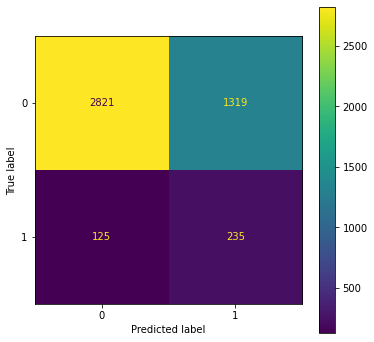

--- ROC AUC ---------------------------------------------------------------------------------------- 



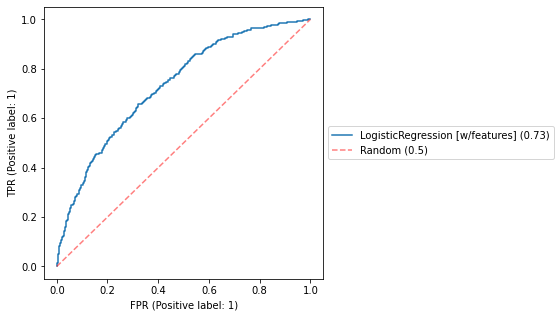

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



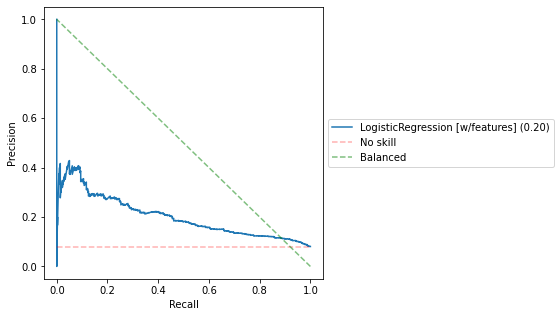

In [57]:
get_scores(f"{model_name} [w/features]", **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [58]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23008727922479555) for this model is reached with a threshold of 0.402


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features] ----------------------------------------------------

             ROC_AUC : 0.7320
                  F1 : 0.2143
            ACCURACY : 0.5438
           PRECISION : 0.1243
              RECALL : 0.7778
   AVERAGE_PRECISION : 0.2026
              CUSTOM : 0.3791

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.52      0.68      4140
Prediction = 1       0.12      0.78      0.21       360

      accuracy                           0.54      4500
     macro avg       0.54      0.65      0.45      45

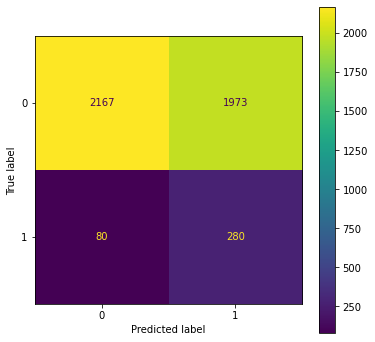

In [59]:
get_scores(f"{model_name} [w/threshold + features]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [60]:
from xgboost import XGBClassifier

In [61]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [62]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [63]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6522
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6759
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7140
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6481
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6989

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6778 (std:0.0443)

----------------------------------------------------------------------------------------------------


In [64]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features] ---------------------------------------------------------------------

             ROC_AUC : 0.7242
                  F1 : 0.2437
            ACCURACY : 0.6773
           PRECISION : 0.1500
              RECALL : 0.6500
   AVERAGE_PRECISION : 0.2036
              CUSTOM : 0.3900

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

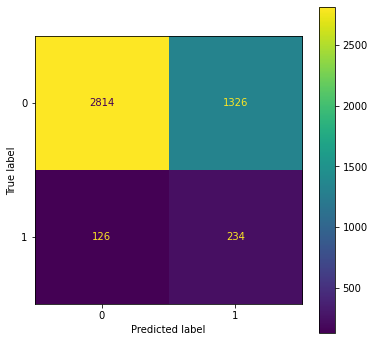

--- ROC AUC ---------------------------------------------------------------------------------------- 



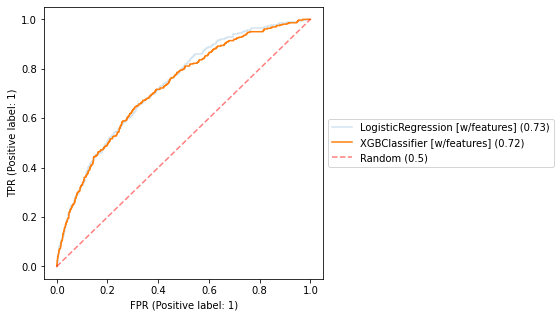

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



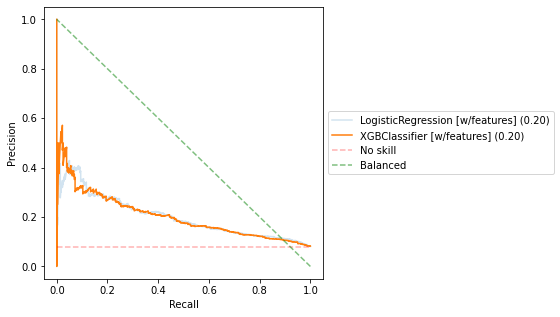

In [65]:
get_scores(f"{model_name} [w/features]", **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [66]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.1981196491412364) for this model is reached with a threshold of 0.34900000000000003


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/thresholding + features] ------------------------------------------------------

             ROC_AUC : 0.7242
                  F1 : 0.1894
            ACCURACY : 0.3873
           PRECISION : 0.1059
              RECALL : 0.8944
   AVERAGE_PRECISION : 0.2036
              CUSTOM : 0.3593

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.34      0.51      4140
Prediction = 1       0.11      0.89      0.19       360

      accuracy                           0.39      4500
     macro avg       0.54      0.62      0.35      45

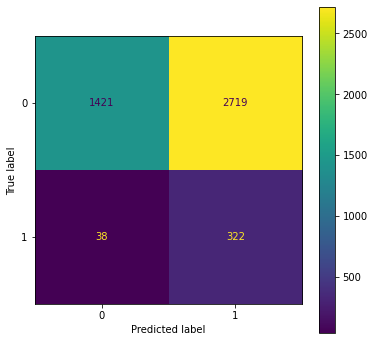

In [67]:
get_scores(f"{model_name} [w/thresholding + features]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [68]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
0,LogisticRegression [w/features],0.732030,0.245559,0.151223,0.652778
2,XGBClassifier [w/features],0.724231,0.243750,0.150000,0.650000


In [69]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
1,LogisticRegression [w/threshold + features],0.732030,0.214313,0.124279,0.777778
3,XGBClassifier [w/thresholding + features],0.724231,0.189356,0.105886,0.894444


#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [70]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


# Feature selection

## Select without model

In [71]:
from sklearn.feature_selection import SelectKBest, chi2

In [72]:
selector2 = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [73]:
X_train.columns[selector2.get_support()]

Index(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3'],
      dtype='object')

## Recursive feature elimination with cross-validation

In [74]:
from sklearn.feature_selection import RFECV

In [75]:
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=grd_log['model'],
    step=1,
    cv=skfold,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
      estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                   max_iter=3000, random_state=0,
                                   solver='liblinear'),
      scoring='roc_auc')

Optimal number of features : 88


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


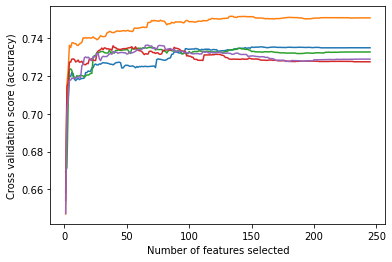

In [76]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [77]:
rfecv.n_features_

88

In [78]:
selected_cols = X_train.columns[rfecv.get_support()]
selected_cols

Index(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_True', 'NAME_TYPE_SUITE_Group of people',
       'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B',
       'NAME_TYPE_SUITE_nan', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Municipal apartment', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff',
       'OCCUPATION_TYPE_Low-skill Laborers',
       'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Secretaries',
       'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Culture',
       'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Hotel',
       'ORGANIZATION_TYPE_Industry: type 11',
       'ORGANIZATION_TYPE_Industry: type 2',
       'ORGANIZATION_TYPE_Industry: type 5',
       'ORGANIZATION_TYPE_Industry: type 9',
       'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Military',
       'ORGANIZATION_TYPE_Police', 'ORGANIZA

In [79]:
X_train[selected_cols].shape

(25500, 88)

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [82]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    X_ref=X_train[selected_cols],
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6536
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6211
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6150
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6690
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7040

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6526 (std:0.0475)

----------------------------------------------------------------------------------------------------


In [83]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + rec_selection] ------------------------------------------------

             ROC_AUC : 0.7324
                  F1 : 0.2427
            ACCURACY : 0.6769
           PRECISION : 0.1494
              RECALL : 0.6472
   AVERAGE_PRECISION : 0.2002
              CUSTOM : 0.3883

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

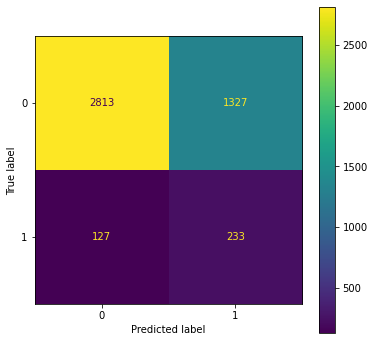

--- ROC AUC ---------------------------------------------------------------------------------------- 



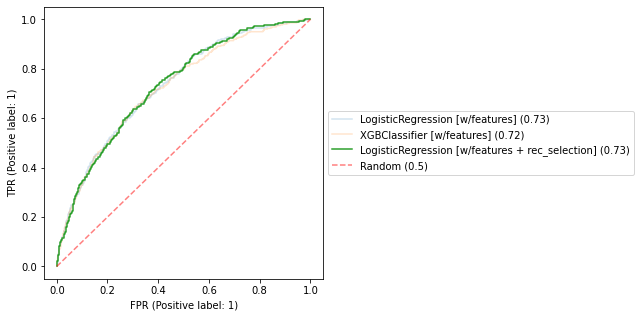

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



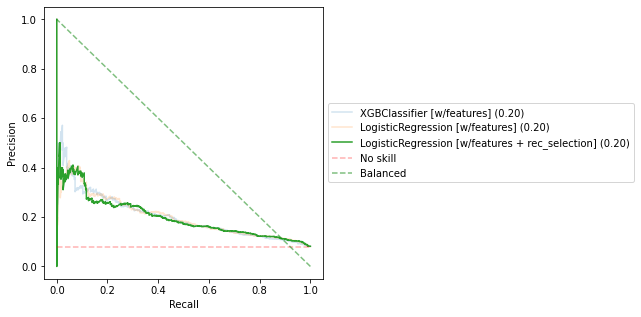

In [84]:
get_scores(f"{model_name} [w/features + rec_selection]", **grd_log, X_ref=X_test[selected_cols], register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [85]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train[selected_cols], y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23963963963963963) for this model is reached with a threshold of 0.432


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + rec_selection] ------------------------------------

             ROC_AUC : 0.7324
                  F1 : 0.2273
            ACCURACY : 0.5829
           PRECISION : 0.1334
              RECALL : 0.7667
   AVERAGE_PRECISION : 0.2002
              CUSTOM : 0.3933

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.57      0.71      4140
Prediction = 1       0.13      0.77      0.23       360

      accuracy                           0.58      4500
     macro avg       0.55      0.67      0.47      45

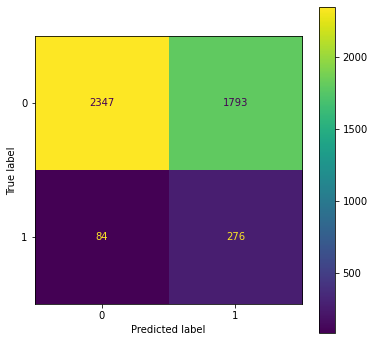

In [86]:
get_scores(f"{model_name} [w/threshold + features + rec_selection]", **grd_log, threshold=best_threshold, X_ref=X_test[selected_cols], register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [87]:
from xgboost import XGBClassifier

In [88]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [89]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [90]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    X_ref=X_train[selected_cols],
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6161
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6721
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7092
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6883
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5880

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6548 (std:0.0555)

----------------------------------------------------------------------------------------------------


In [91]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + rec_selection] -----------------------------------------------------

             ROC_AUC : 0.7247
                  F1 : 0.2373
            ACCURACY : 0.6729
           PRECISION : 0.1459
              RECALL : 0.6361
   AVERAGE_PRECISION : 0.2099
              CUSTOM : 0.3804

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.64      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.51      45

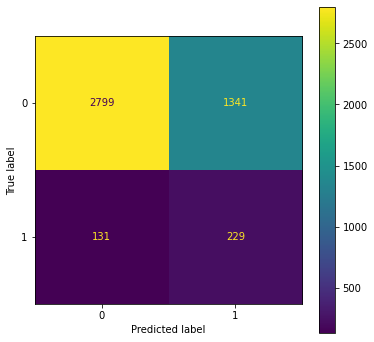

--- ROC AUC ---------------------------------------------------------------------------------------- 



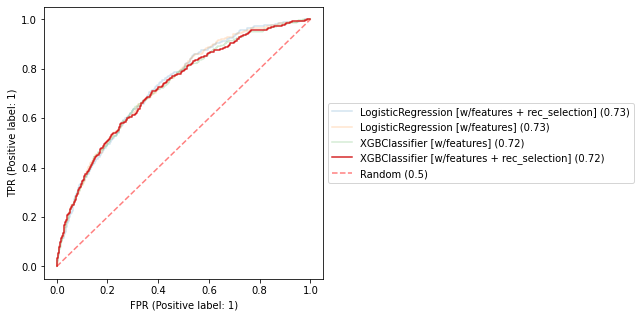

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



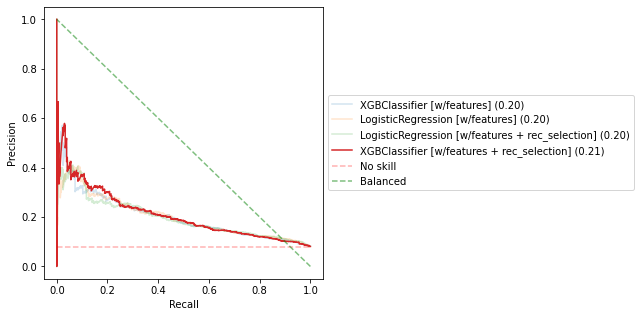

In [92]:
get_scores(f"{model_name} [w/features + rec_selection]", **grd_xgb, X_ref=X_test[selected_cols], register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [93]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train[selected_cols], y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20931833830617397) for this model is reached with a threshold of 0.371


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + rec_selection] -----------------------------------------

             ROC_AUC : 0.7247
                  F1 : 0.1978
            ACCURACY : 0.4429
           PRECISION : 0.1118
              RECALL : 0.8583
   AVERAGE_PRECISION : 0.2099
              CUSTOM : 0.3674

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.41      0.57      4140
Prediction = 1       0.11      0.86      0.20       360

      accuracy                           0.44      4500
     macro avg       0.54      0.63      0.39      45

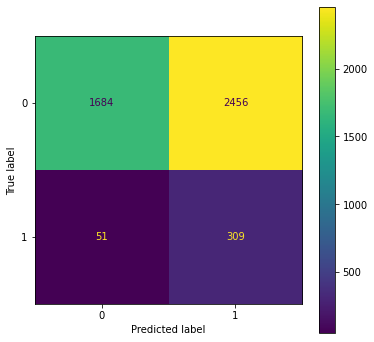

In [94]:
get_scores(f"{model_name} [w/threshold + features + rec_selection]", **grd_xgb, threshold=best_threshold, X_ref=X_test[selected_cols], register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [95]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
0,LogisticRegression [w/features],0.732030,0.245559,0.151223,0.652778
2,XGBClassifier [w/features],0.724231,0.243750,0.150000,0.650000
4,LogisticRegression [w/features + rec_selection],0.732358,0.242708,0.149359,0.647222
6,XGBClassifier [w/features + rec_selection],0.724667,0.237306,0.145860,0.636111


In [96]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
1,LogisticRegression [w/threshold + features],0.732030,0.214313,0.124279,0.777778
3,XGBClassifier [w/thresholding + features],0.724231,0.189356,0.105886,0.894444
5,LogisticRegression [w/threshold + features + r...,0.732358,0.227254,0.133398,0.766667
7,XGBClassifier [w/threshold + features + rec_se...,0.724667,0.197760,0.111754,0.858333


#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [97]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


## Feature Selection with Null Importances 

In [98]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [99]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

import time
import gc
gc.enable()

In [100]:
def get_feature_importances(data, shuffle, categorical_feats, seed=None, ):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4,
        'verbose':-1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats, verbose_eval=-1)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [101]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        'verbose':-1
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

In [102]:
def nimp_feature_selection(data):
    """
    Feature Selection with Null Importances based on the method of the Kaggle competition winner Olivier Grellier.
    https://www.kaggle.com/code/ogrellier/feature-selection-with-null-importances/comments
    
    - “split” contains numbers of times the feature is used in a model.
    - “gain”, contains total gains of splits which use the feature.
    """
    
    # Encode categorical
    print(" Encoding categorical ".center(100,'-'))
    data = data.copy()
    categorical_feats = [f for f in data.columns if data[f].dtype == 'object']

    for f_ in categorical_feats:
        data[f_], _ = pd.factorize(data[f_])
        data[f_] = data[f_].astype('category')
        
    # Get the actual importance, i.e. without shuffling
    print(" Getting the actual importance ".center(100,'-'))
    actual_imp_df = get_feature_importances(data=data, shuffle=False, categorical_feats=categorical_feats)
    
    # Build Null Importances distribution
    print(" Getting the null importance ".center(100,'-'))
    null_imp_df = pd.DataFrame()
    nb_runs = 80
    start = time.time()
    
    for i in range(nb_runs):
        imp_df = get_feature_importances(data=data, shuffle=True, categorical_feats=categorical_feats)
        imp_df['run'] = i + 1 
        null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
        spent = (time.time() - start) / 60
        print(f"Done with {i+1} of {nb_runs} (Spent {spent:.1f} min)", end='\r')
    print("")
        
    # Search best threshold
    print(" Searching for the best threshold ".center(100,'-'))
    best_split_threshold, best_split_value = None, 0
    best_gain_threshold, best_gain_value = None, 0
    
    correlation_scores = get_scores_B(actual_imp_df, null_imp_df).to_numpy()
    
    for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
        
        split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
        split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
        gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
        gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
        print('Results for threshold %3d' % threshold)
        split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
        print(f'\t SPLIT : {split_results[0]:.6f} +/- {split_results[1]:.6f}')
        gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
        print(f'\t GAIN : {gain_results[0]:.6f} +/- {gain_results[1]:.6f}')
        
        if(split_results[0] > best_split_value):
            best_split_value, best_split_threshold = split_results[0], threshold
        
        if(gain_results[0] > best_gain_value):
            best_gain_value, best_gain_threshold = gain_results[0], threshold
            
    print(f"Best SPLIT : {best_split_value} (thresold: {best_split_threshold})")
    print(f"Best GAIN : {best_gain_value} (thresold: {best_gain_threshold})")
            
    # Select columns
    print(" Selecting the columns ".center(100,'-'))
    if best_gain_value > best_split_value:
        selected_cols = [_f for _f, _, _score in correlation_scores if _score >= best_gain_threshold]
    else:
        selected_cols = [_f for _f, _score, _ in correlation_scores if _score >= best_split_threshold]
        
    print(f"The selection contains {len(selected_cols)} columns\n{selected_cols}")
    
    return actual_imp_df, null_imp_df, selected_cols

In [103]:
import matplotlib.gridspec as gridspec

def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

In [104]:
def get_scores_A(actual_imp_df_, null_imp_df_):
    
    feature_scores = []
    
    for _f in actual_imp_df_['feature'].unique():
        
        f_null_imps_gain = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_gain'].values
        f_act_imps_gain = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_gain'].mean()
        gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid divide by zero
        
        f_null_imps_split = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_split'].values
        f_act_imps_split = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_split'].mean()
        split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid divide by zero
        
        feature_scores.append((_f, split_score, gain_score))
        
    return pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])


def get_scores_B(actual_imp_df_, null_imp_df_):
    
    correlation_scores = []
    
    for _f in actual_imp_df_['feature'].unique():
        
        f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_gain'].values
        f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_gain'].values
        gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        
        f_null_imps = null_imp_df_.loc[null_imp_df_['feature'] == _f, 'importance_split'].values
        f_act_imps = actual_imp_df_.loc[actual_imp_df_['feature'] == _f, 'importance_split'].values
        split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        
        correlation_scores.append((_f, split_score, gain_score))

    return pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])


def display_split_gain_importance(scores_df):

    plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
    ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
    ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
    plt.tight_layout()

In [105]:
actual_imp_df, null_imp_df, selected_cols = nimp_feature_selection(data_work2)

--------------------------------------- Encoding categorical ---------------------------------------
---------------------------------- Getting the actual importance -----------------------------------
----------------------------------- Getting the null importance ------------------------------------
Done with 80 of 80 (Spent 4.0 min)
--------------------------------- Searching for the best threshold ---------------------------------
Results for threshold   0
	 SPLIT : 0.733240 +/- 0.006986
	 GAIN : 0.733240 +/- 0.006986
Results for threshold  10
	 SPLIT : 0.737903 +/- 0.006146
	 GAIN : 0.737804 +/- 0.004140
Results for threshold  20
	 SPLIT : 0.739579 +/- 0.006735
	 GAIN : 0.733061 +/- 0.005147
Results for threshold  30
	 SPLIT : 0.736478 +/- 0.007444
	 GAIN : 0.729950 +/- 0.007502
Results for threshold  40
	 SPLIT : 0.738931 +/- 0.006267
	 GAIN : 0.734140 +/- 0.004428
Results for threshold  50
	 SPLIT : 0.738801 +/- 0.009970
	 GAIN : 0.732636 +/- 0.003463
Results for threshold  60
	

### Préparation des données <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

#### Split

In [106]:
X_full_s = data_work2[selected_cols].copy()
Y_full_s = data_work2['TARGET']

In [107]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
                                                X_full_s, 
                                                Y_full_s, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [108]:
print(f"X_train: {X_train_s.shape[0] / X_full_s.shape[0] * 100}% | X_test: {X_test_s.shape[0] / X_full_s.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


#### Encodage

In [109]:
oe_model_s, ohe_model_s = fit_labels(X_train_s)

In [110]:
ohe_model_s.feature_names_in_

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'EMERGENCYSTATE_MODE'],
      dtype=object)

In [111]:
X_train_s = transform_labels(X_train_s, oe_model_s, ohe_model_s)
X_test_s = transform_labels(X_test_s, oe_model_s, ohe_model_s)

#### Imputation

In [112]:
imputer_model_s = fit_imputer(X_train_s, X_train_s.select_dtypes(include='number').columns)

In [113]:
X_train_s = impute(X_train_s, imputer_model_s)
X_test_s = impute(X_test_s, imputer_model_s)

#### Normalization

In [114]:
model_scaler_s = fit_normalizer(X_train_s)

In [115]:
X_train_s = normalize(X_train_s, model_scaler_s)
X_test_s = normalize(X_test_s, model_scaler_s)

In [116]:
X_train_s.shape

(25500, 57)

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [117]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [118]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    X_ref=X_train_s,
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6595
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6448
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6719
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6431
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6935

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6626 (std:0.0385)

----------------------------------------------------------------------------------------------------


In [119]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + nimp_selection] -----------------------------------------------

             ROC_AUC : 0.7276
                  F1 : 0.2411
            ACCURACY : 0.6727
           PRECISION : 0.1480
              RECALL : 0.6500
   AVERAGE_PRECISION : 0.2046
              CUSTOM : 0.3873

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.52      45

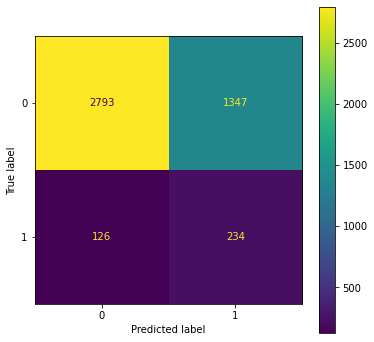

--- ROC AUC ---------------------------------------------------------------------------------------- 



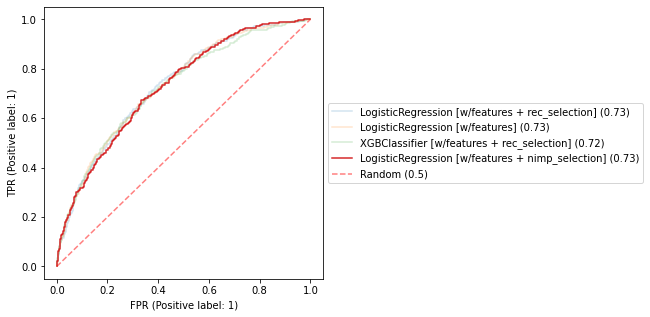

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



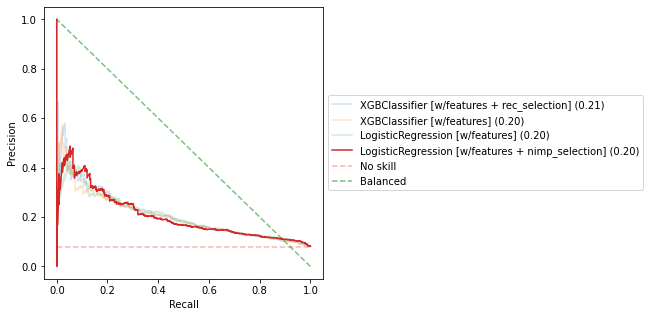

In [120]:
get_scores(f"{model_name} [w/features + nimp_selection]", **grd_log, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [121]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.19700237222342032) for this model is reached with a threshold of 0.331


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + nimp_selection] -----------------------------------

             ROC_AUC : 0.7276
                  F1 : 0.1956
            ACCURACY : 0.4113
           PRECISION : 0.1098
              RECALL : 0.8944
   AVERAGE_PRECISION : 0.2046
              CUSTOM : 0.3682

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.98      0.37      0.54      4140
Prediction = 1       0.11      0.89      0.20       360

      accuracy                           0.41      4500
     macro avg       0.54      0.63      0.37      45

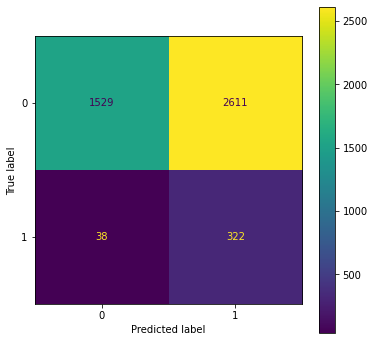

In [122]:
get_scores(f"{model_name} [w/threshold + features + nimp_selection]", **grd_log, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [123]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [124]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [125]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    X_ref=X_train_s,
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6758
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6684
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7178
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6560
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6401

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6717 (std:0.0414)

----------------------------------------------------------------------------------------------------


In [126]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + nimp_selection] ----------------------------------------------------

             ROC_AUC : 0.7245
                  F1 : 0.2406
            ACCURACY : 0.6760
           PRECISION : 0.1481
              RECALL : 0.6417
   AVERAGE_PRECISION : 0.2073
              CUSTOM : 0.3850

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.64      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      45

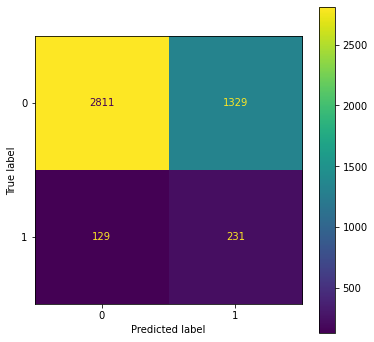

--- ROC AUC ---------------------------------------------------------------------------------------- 



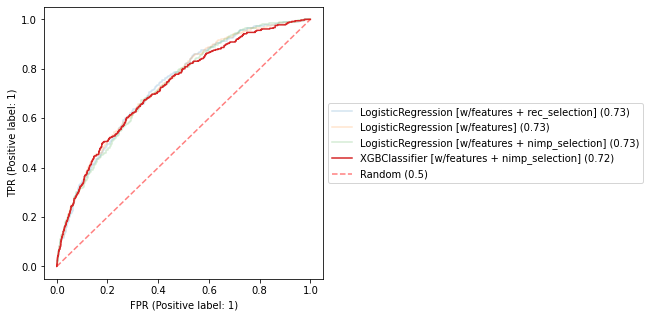

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



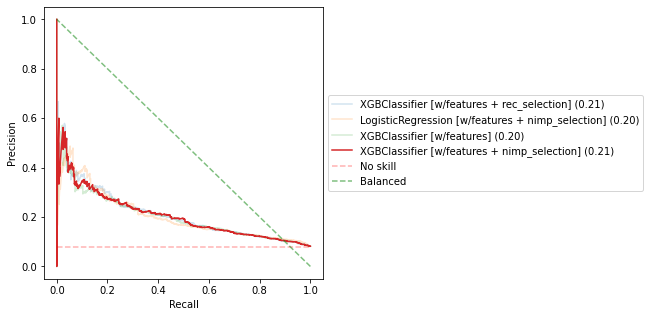

In [127]:
get_scores(f"{model_name} [w/features + nimp_selection]", **grd_xgb, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [128]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.29239349709267826) for this model is reached with a threshold of 0.546


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + nimp_selection] ----------------------------------------

             ROC_AUC : 0.7245
                  F1 : 0.2521
            ACCURACY : 0.7442
           PRECISION : 0.1645
              RECALL : 0.5389
   AVERAGE_PRECISION : 0.2073
              CUSTOM : 0.3704

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.76      0.85      4140
Prediction = 1       0.16      0.54      0.25       360

      accuracy                           0.74      4500
     macro avg       0.56      0.65      0.55      45

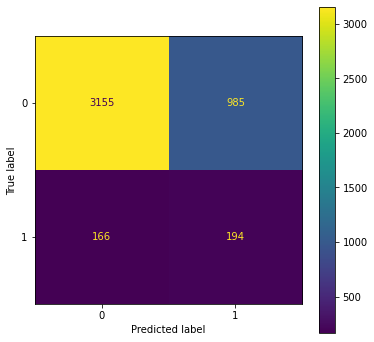

In [129]:
get_scores(f"{model_name} [w/threshold + features + nimp_selection]", **grd_xgb, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [130]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
0,LogisticRegression [w/features],0.732030,0.245559,0.151223,0.652778
2,XGBClassifier [w/features],0.724231,0.243750,0.150000,0.650000
4,LogisticRegression [w/features + rec_selection],0.732358,0.242708,0.149359,0.647222
6,XGBClassifier [w/features + rec_selection],0.724667,0.237306,0.145860,0.636111
8,LogisticRegression [w/features + nimp_selection],0.727618,0.241113,0.148008,0.650000
10,XGBClassifier [w/features + nimp_selection],0.724475,0.240625,0.148077,0.641667


In [131]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
1,LogisticRegression [w/threshold + features],0.732030,0.214313,0.124279,0.777778
3,XGBClassifier [w/thresholding + features],0.724231,0.189356,0.105886,0.894444
5,LogisticRegression [w/threshold + features + r...,0.732358,0.227254,0.133398,0.766667
7,XGBClassifier [w/threshold + features + rec_se...,0.724667,0.197760,0.111754,0.858333
9,LogisticRegression [w/threshold + features + n...,0.727618,0.195566,0.109785,0.894444
11,XGBClassifier [w/threshold + features + nimp_s...,0.724475,0.252112,0.164546,0.538889


#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [132]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [133]:
from sklearn.metrics import fbeta_score, make_scorer

In [134]:
f2_score = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2)

In [135]:
f2_scorer = make_scorer(fbeta_score, beta=2)

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [136]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [137]:
model_name = "LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.1838
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.2948
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.2707
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.3009
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.2785

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.2657 (std:0.0544)

---------------

In [138]:
grd_log['grid'].best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/features + custom_metric] ------------------------------------------------

             ROC_AUC : 0.7126
                  F1 : 0.2304
            ACCURACY : 0.6527
           PRECISION : 0.1400
              RECALL : 0.6500
   AVERAGE_PRECISION : 0.1765
              CUSTOM : 0.3761

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.65      0.78      4140
Prediction = 1       0.14      0.65      0.23       360

      accuracy                           0.65      4500
     macro avg       0.55      0.65      0.50      45

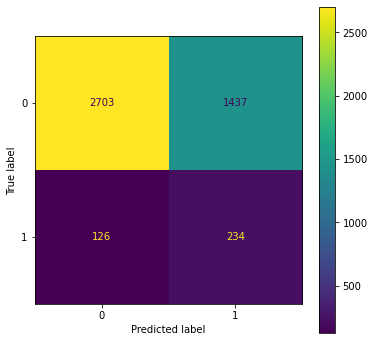

--- ROC AUC ---------------------------------------------------------------------------------------- 



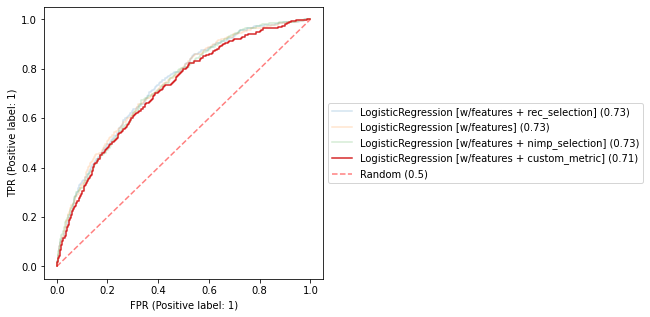

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



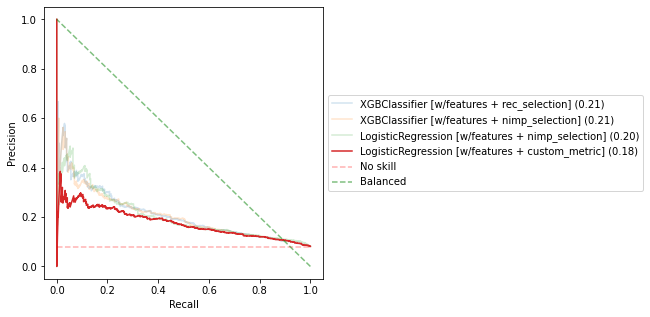

In [139]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [140]:
f2_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.3530885758760773) for this model is reached with a threshold of 0.40700000000000003


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression [w/threshold + features + custom_metric] ------------------------------------

             ROC_AUC : 0.7126
                  F1 : 0.1848
            ACCURACY : 0.3551
           PRECISION : 0.1028
              RECALL : 0.9139
   AVERAGE_PRECISION : 0.1765
              CUSTOM : 0.3545

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.98      0.31      0.47      4140
Prediction = 1       0.10      0.91      0.18       360

      accuracy                           0.36      4500
     macro avg       0.54      0.61      0.33      45

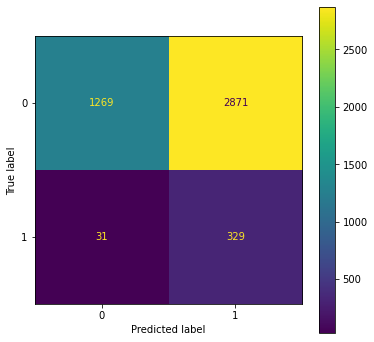

In [141]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [142]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [143]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [144]:
model_name = "XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold,
    scoring=f2_scorer,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.1368
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.1726
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.2279
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.1870
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | MAKE_SCORER(FBETA_SCORE, BETA=2): 0.0948

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- MAKE_SCORER(FBETA_SCORE, BETA=2): 0.1638 (std:0.0703)

---------------

In [145]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/features + custom_metric] -----------------------------------------------------

             ROC_AUC : 0.7143
                  F1 : 0.2378
            ACCURACY : 0.6667
           PRECISION : 0.1455
              RECALL : 0.6500
   AVERAGE_PRECISION : 0.1955
              CUSTOM : 0.3839

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.51      45

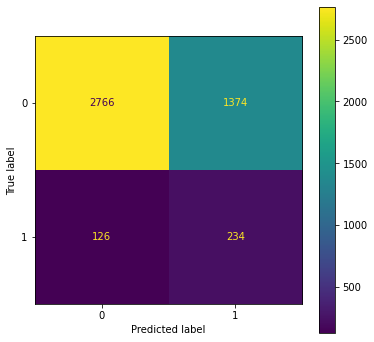

--- ROC AUC ---------------------------------------------------------------------------------------- 



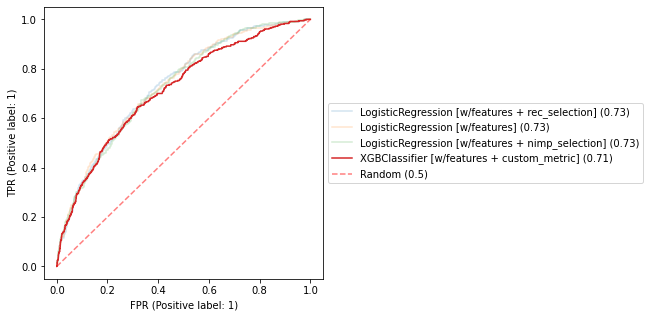

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



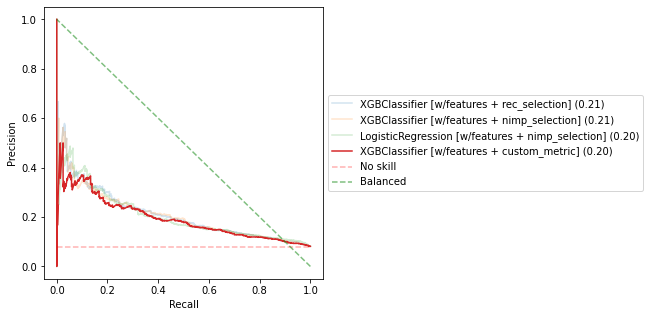

In [146]:
get_scores(f"{model_name} [w/features + custom_metric]", **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [147]:
f2_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f2_score)
print(f"The best F2 score ({f2_value}) for this model is reached with a threshold of {best_threshold}")

The best F2 score (0.3861632376215238) for this model is reached with a threshold of 0.423


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- XGBClassifier [w/threshold + features + custom_metric] -----------------------------------------

             ROC_AUC : 0.7143
                  F1 : 0.2040
            ACCURACY : 0.4900
           PRECISION : 0.1165
              RECALL : 0.8167
   AVERAGE_PRECISION : 0.1955
              CUSTOM : 0.3709

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.46      0.62      4140
Prediction = 1       0.12      0.82      0.20       360

      accuracy                           0.49      4500
     macro avg       0.54      0.64      0.41      45

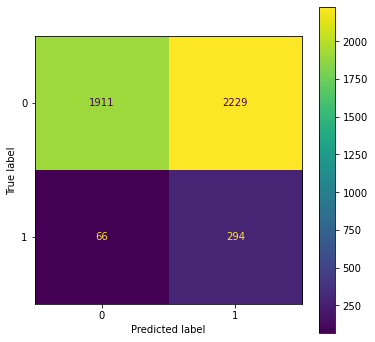

In [148]:
get_scores(f"{model_name} [w/threshold + features + custom_metric]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [153]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall','Custom']]

,Method,ROC AUC,F1 score,Precision,Recall,Custom
0,LogisticRegression [w/features],0.732030,0.245559,0.151223,0.652778,0.392452
2,XGBClassifier [w/features],0.724231,0.243750,0.150000,0.650000,0.390000
4,LogisticRegression [w/features + rec_selection],0.732358,0.242708,0.149359,0.647222,0.388333
6,XGBClassifier [w/features + rec_selection],0.724667,0.237306,0.145860,0.636111,0.380399
8,LogisticRegression [w/features + nimp_selection],0.727618,0.241113,0.148008,0.650000,0.387289
10,XGBClassifier [w/features + nimp_selection],0.724475,0.240625,0.148077,0.641667,0.385000
12,LogisticRegression [w/features + custom_metric],0.712618,0.230428,0.140036,0.650000,0.376085
14,XGBClassifier [w/features + custom_metric],0.714255,0.237805,0.145522,0.650000,0.383858


In [154]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall', 'Custom']]

,Method,ROC AUC,F1 score,Precision,Recall,Custom
1,LogisticRegression [w/threshold + features],0.732030,0.214313,0.124279,0.777778,0.379096
3,XGBClassifier [w/thresholding + features],0.724231,0.189356,0.105886,0.894444,0.359295
5,LogisticRegression [w/threshold + features + r...,0.732358,0.227254,0.133398,0.766667,0.393274
7,XGBClassifier [w/threshold + features + rec_se...,0.724667,0.197760,0.111754,0.858333,0.367420
9,LogisticRegression [w/threshold + features + n...,0.727618,0.195566,0.109785,0.894444,0.368168
11,XGBClassifier [w/threshold + features + nimp_s...,0.724475,0.252112,0.164546,0.538889,0.370370
13,LogisticRegression [w/threshold + features + c...,0.712618,0.184831,0.102813,0.913889,0.354526
15,XGBClassifier [w/threshold + features + custom...,0.714255,0.203954,0.116528,0.816667,0.370931


#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [156]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


In [152]:
sms.send()

JupyterScriptCompleted: Jupyter is waiting